## 이상치 처리 및 상관 분석

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
plt.style.use('seaborn')

In [2]:
# 구글 드라이브에 mount
from google.colab import drive 
drive.mount('/content/drive')

# colab 파일에 drive 폴더가 생긴 것 확인

Mounted at /content/drive


### 실습 데이터: 사출 성형 AI Dataset
- 사출 성형(injection molding)
 - 플라스틱 성형법의 하나로, 열가소성 수지를 가열하여 유동 상태가 되었을 때 금형의 공동부(Cavity, 캐비티)에 가압 주입 후 금형 내에서 냉각시킴으로써, 금형의 공동부에 상당하는 성형품을 만드는 방법
- [KAMP(인공지능 중소벤처 제조 플랫폼)](https://www.kamp-ai.kr/front/main/MAIN.01.01.jsp)
 - 제조 AI 데이터셋 > 사출성형기 AI 데이터셋 > labeled_data.csv
 - 중소벤처기업부, Korea AI Manufacturing Platform(KAMP),
 사출성형기 AI 데이터셋, KAIST(UNIST, 이피엠솔루션즈), 2020.12.14.,
 https://kamp-ai.kr

### 분석 목표
- 사출 공정에서 발생하는 품질 문제와 생산 조건 데이터를 검토하여 데이터 간의 상관관계를 찾고 주요 문제별 원인 인자를 분석
- 다양한 기계 학습(machine learning) 알고리즘을 활용하여 사출 공정 불량 예측 모델과 생산 조건 최적화 모델 생성
- [KAMP 분석지원도구](https://www.kamp-ai.kr/front/analysis/analysis-tool.jsp)
 - 목표하는 분석 결과 화면 확인 가능
 - 기술통계 > 데이터 입력(labeled_data.csv) > 결측치 및 이상치 제거 > 변수 선택

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/0_머신러닝/labeled_data.csv'

# csv 파일을 데이터프레임에 저장
df = pd.read_csv(path)
df.head()

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,Injection_Time,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.59,...,24.799999,27.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.60,...,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.60,...,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5f8928f39c0189cc666ef25e,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,23,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,None,9.59,...,25.000000,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5f8928f59c0189cc666ef265,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,None,9.59,...,25.000000,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
##### 분석에 사용할 feature #####

# Cycle_Time: 한 번의 제품 생산에 소요되는 생산 시간
# Max_Screw_RPM: 사출을 위한 screw의 최대 속도
# Hopper_Temperature: 재료 주입구의 온도

# 충분히 건조시키고 재료가 용융되는 시간을 절약하기 위해 재료 주입구의 온도가 높아야 함

In [5]:
# 데이터 크기 확인
df.shape

(7996, 45)

In [6]:
# 데이터 기본정보 확인(컬럼명, 데이터 타입 등)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       7996 non-null   object 
 1   TimeStamp                 7996 non-null   object 
 2   PART_FACT_PLAN_DATE       7996 non-null   object 
 3   PART_FACT_SERIAL          7996 non-null   int64  
 4   PART_NAME                 7996 non-null   object 
 5   EQUIP_CD                  7996 non-null   object 
 6   EQUIP_NAME                7996 non-null   object 
 7   PassOrFail                7996 non-null   object 
 8   Reason                    7996 non-null   object 
 9   Injection_Time            7996 non-null   float64
 10  Filling_Time              7996 non-null   float64
 11  Plasticizing_Time         7996 non-null   float64
 12  Cycle_Time                7996 non-null   float64
 13  Clamp_Close_Time          7996 non-null   float64
 14  Cushion_

In [7]:
# 컬럼별 결측치 개수 조회
# df.isnull().sum()

# 전체 데이터 결측치 개수 조회
df.isnull().sum().sum()

0

## 이상치 탐지
- IQR(InterQuartile Range) 또는 Z-score 활용
- 일반적으로 IQR 방식이 훨씬 많은 수의 이상치를 탐지
- 너무 많은 데이터를 제거하지 않기 위해 Z-score 방식을 주로 사용

### 시각화

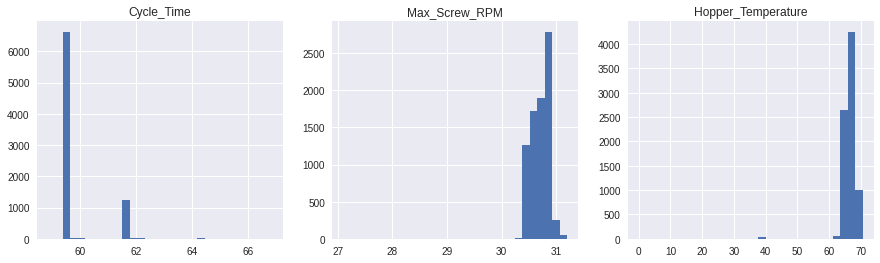

In [8]:
# 히스토그램(histogram)

cols = ['Cycle_Time', 'Max_Screw_RPM', 'Hopper_Temperature'] # 컬럼 리스트

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cols):
    axes[i].hist(df[col], bins=30) # default: bins=10
    axes[i].set_title(cols[i])

plt.show()

# 이상치로 인해 3개의 feature 모두 그래프가 한 쪽으로 치우친 모습

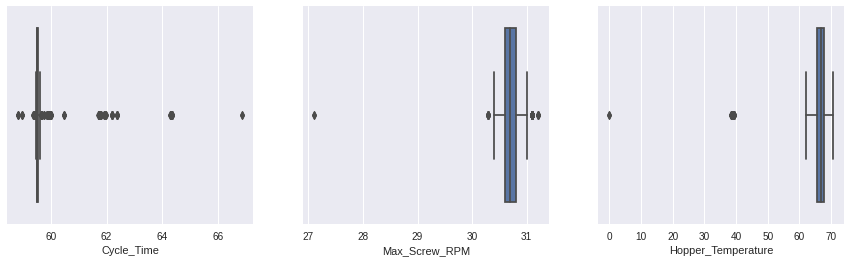

In [9]:
# 상자 그림(box plot): seaborn 활용

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cols):
    sns.boxplot(df[col], ax=axes[i])

plt.show()

# 이상치로 인해 치우친 분포

### 왜도

In [10]:
df['Cycle_Time'].skew()

2.1239773952655088

In [11]:
df['Max_Screw_RPM'].skew()

-2.854245309973676

In [12]:
df['Hopper_Temperature'].skew()

# 데이터가 한 쪽으로 심하게 치우친 것 확인

-9.977352468785194

### IQR

In [13]:
# IQR 이상치 탐지 함수 구현

import numpy as np

def outliers_iqr(data): # data(feature)를 인자로 받는 함수

    q1 = np.percentile(data, 25) # Q1(25%)
    q3 = np.percentile(data, 75) # Q3(75%)
    
    iqr = q3-q1 # IQR
    
    lower_bound = q1 - (1.5*iqr) # 하한(min)
    upper_bound = q3 + (1.5*iqr) # 상한(max)

    return data[(data > upper_bound) | (data < lower_bound)].index # 이상치 인덱스 반환

In [14]:
# Max_Screw_RPM 컬럼의 이상치 확인

outliers = outliers_iqr(df['Max_Screw_RPM'])

print(len(outliers)) # 이상치 개수
print(len(outliers) / df.shape[0] * 100) # 이상치 비율(%)
outliers # 이상치 인덱스(위치)

68
0.8504252126063032


Int64Index([ 579,  580,  721,  724,  865,  866,  979,  980,  993,  994, 1027,
            1028, 1041, 1042, 1081, 1082, 1095, 1096, 1105, 1106, 1149, 1150,
            1183, 1184, 1193, 1194, 1209, 1210, 2467, 2468, 3021, 3160, 3289,
            3538, 3721, 3722, 3748, 3807, 3808, 5161, 5162, 5169, 5170, 5193,
            5194, 5195, 5196, 5199, 5200, 5213, 5214, 5215, 5216, 5221, 5222,
            5227, 5228, 5305, 5306, 5859, 5998, 6127, 6376, 6559, 6560, 6586,
            6645, 6646],
           dtype='int64')

In [15]:
# Hopper_Temperature
outliers = outliers_iqr(df['Hopper_Temperature'])

print(len(outliers))
print(len(outliers) / df.shape[0] * 100)
outliers

40
0.5002501250625313


Int64Index([3021, 3026, 3027, 3028, 3029, 3039, 3068, 3160, 3236, 3262, 3289,
            3532, 3533, 3538, 3552, 3614, 3635, 3674, 3736, 4421, 5859, 5864,
            5865, 5866, 5867, 5877, 5906, 5998, 6074, 6100, 6127, 6370, 6371,
            6376, 6390, 6452, 6473, 6512, 6574, 7259],
           dtype='int64')

In [16]:
# Cycle_Time
outliers = outliers_iqr(df['Cycle_Time'])

print(len(outliers))
print(len(outliers) / df.shape[0] * 100)

# 전체 데이터 대비 이상치 비율이 매우 높음(19.6%)
# 따라서 IQR을 활용한 이상치 탐지 방식은 데이터 처리에 부적합

1568
19.609804902451224


### Z-score

In [17]:
# z-score 이상치 탐지 함수 구현

def outliers_zscore(data):

    threshold = 3

    mean = np.mean(data)
    std = np.std(data)

    z_score = [(y - mean) / std  for y in data]

    return data[np.abs(z_score) > threshold].index # 이상치 인덱스 반환

In [18]:
# 3개 feature 이상치의 인덱스를 저장할 리스트 생성
outliers = []

# 모든 이상치 인덱스를 모은 후 중복값을 한 번에 제거하려는 목적

In [19]:
# outliers 리스트에 Hopper_Temperature 이상치 인덱스 저장

outlier_z = outliers_zscore(df['Hopper_Temperature'])

for i in outlier_z:
    outliers.append(i)

In [20]:
# Max_Screw_RPM
outlier_z = outliers_zscore(df['Max_Screw_RPM'])

for i in outlier_z:
    outliers.append(i)

In [21]:
# Cycle_Time
outlier_z = outliers_zscore(df['Cycle_Time'])

for i in outlier_z:
    outliers.append(i)

In [22]:
print(len(outliers)) # 중복 제거 전
print(len(set(outliers))) # 중복 제거 후

# 중복을 허용하지 않는 set 자료형을 활용한 중복 제거
outliers = set(outliers)

86
46


### 이상치 제거 및 데이터 시각화

In [23]:
# 이상치 제거
df.drop(outliers, inplace=True)

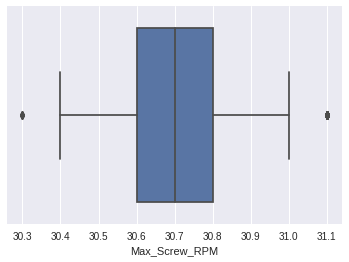

In [24]:
# Max_Screw_RPM
sns.boxplot(df['Max_Screw_RPM'])
plt.show()

# 이상치 제거 이전에 비해 비교적 깨끗해진 모습

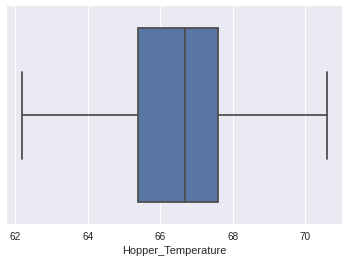

In [25]:
# Hopper_Temperature
sns.boxplot(df['Hopper_Temperature'])
plt.show()

# 이상치 제거 이후 매우 잘 정제된 모습

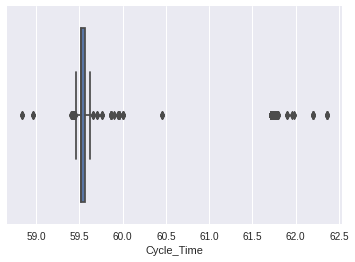

In [26]:
# Cycle_Time
sns.boxplot(df['Cycle_Time'])
plt.show()

# 여전히 다른 두 feature에 비해 이상치가 많이 존재
# Cycle_Time 변수의 특성 상 어쩔 수 없는 문제

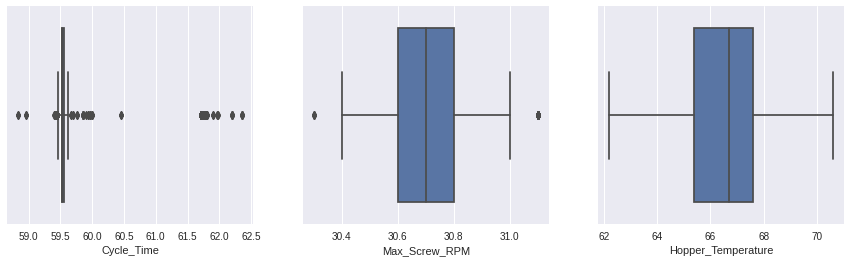

In [27]:
cols = ['Cycle_Time', 'Max_Screw_RPM', 'Hopper_Temperature']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cols):
    sns.boxplot(df[col], ax=axes[i])

plt.show()

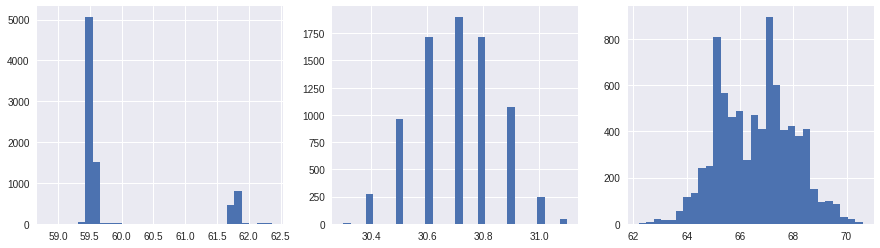

In [28]:
# 히스토그램(histogram)

cols = ['Cycle_Time','Max_Screw_RPM', 'Hopper_Temperature']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cols):
    axes[i].hist(df[col], bins=30)

plt.show()

# 데이터 정제 이전에 비해 정규 분포에 가까운 형태

In [29]:
df['Hopper_Temperature'].skew()

0.032903631167171904

In [30]:
df['Max_Screw_RPM'].skew()

0.035874021845737035

In [31]:
df['Cycle_Time'].skew()

1.8482009652531632

In [32]:
# 정제된 데이터의 첨도 확인
print('Max_Screw_RPM:', df['Max_Screw_RPM'].kurt())
print('Hopper_Temperature:', df['Hopper_Temperature'].kurt())
print('Cycle_Time:', df['Cycle_Time'].kurt())

Max_Screw_RPM: -0.5124684318552224
Hopper_Temperature: -0.572223863143404
Cycle_Time: 1.4534744549304355


## 상관 분석(Correlation Analysis)


In [33]:
# feature 간 상관계수 확인(pearson 상관계수)
corr = df[['Cycle_Time', 'Max_Screw_RPM', 'Hopper_Temperature']].corr()
corr

,Cycle_Time,Max_Screw_RPM,Hopper_Temperature
Cycle_Time,1.000000,0.450674,-0.355813
Max_Screw_RPM,0.450674,1.000000,-0.191448
Hopper_Temperature,-0.355813,-0.191448,1.000000


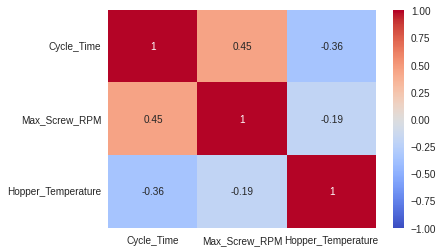

In [34]:
# 상관계수 시각화: 히트맵(heatmap)
sns.heatmap(corr, annot=True, vmin=-1, cmap='coolwarm')
# vmin, vmax: 히트맵 우측 컬러맵(colormap)의 최솟값/최댓값

## 유의확률(p-value)
- stats.pearsonr() 함수를 사용하여 산출
- 유의확률이 0.05보다 작으면 계량화된 상관계수는 의미가 있다고 해석
- 통계학에서 많이 사용하고, 머신러닝 분야에서는 상관관계/상관계수 파악하는 정도

In [35]:
# 지수 형태로 출력되지 않도록 하는 옵션 
np.set_printoptions(suppress=True)

In [36]:
# 유의확률은 통계 툴인 R에서 더 많이 사용되는 개념
# python의 경우 scipy 라이브러리를 사용하여 p-value 산출
from scipy import stats

In [37]:
# 제품 생산 시간(Cycle_Time)과 재료 주입구 온도(Hopper_Temperature)의 상관관계
values = stats.pearsonr(df['Cycle_Time'], df['Hopper_Temperature'])

print(values)
print()
print('Cycle_Time x Hopper_Temperature')
print('='*35)
print(f'Correlation coefficient: {values[0]:.4f}')
print(f'P-value: {values[1]:.4f}') # 0에 가까운 값: p-value < 0.05

(-0.35581271623425254, 5.9716415699783e-236)

Cycle_Time x Hopper_Temperature
Correlation coefficient: -0.3558
P-value: 0.0000


In [38]:
# 상관분석(상관계수 및 유의확률 산출): Cycle_Time, Hopper_Temperature, Max_Screw_RPM

# 상관분석에 사용할 변수
features = ['Cycle_Time', 'Hopper_Temperature', 'Max_Screw_RPM']

# 변수들 간의 상관계수와 유의확률을 저장할 빈 데이터프레임 생성
pearson_df = pd.DataFrame(columns=features)
p_value_df = pd.DataFrame(columns=features)

# pearson_df, p_value_df에 상관계수와 유의확률 값을 추가
for i, f1 in enumerate(features):
    
    # 리스트 초기화
    pearson_v = []
    p_value = []

    for f2 in features:
        
        # 현재 할당된 f1, f2에 대한 연산
        values = stats.pearsonr(df[f1], df[f2])
        
        # 연산 결과 리스트에 추가
        pearson_v.append(values[0])
        p_value.append(values[1])
    
    # 데이터프레임의 i번 인덱스에 결과값(list) 저장 -> len(list): 3
    pearson_df.loc[i] = pearson_v
    p_value_df.loc[i] = p_value


##### for문 연산 순서 #####

#     f1                    f2(append)
# Cycle_Time            Cycle_Time -> Hopper_Temperature -> Max_Screw_RPM
# Hopper_Temperature    Cycle_Time -> Hopper_Temperature -> Max_Screw_RPM
# Max_Screw_RPM         Cycle_Time -> Hopper_Temperature -> Max_Screw_RPM

# 하나의 f1에 대한 연산을 마칠 때마다 데이터프레임에 결과값 저장
# 다음 f1에 대한 연산을 시작하기에 앞서 pearson_v, p_value 리스트 초기화

In [39]:
pearson_df['features'] = features
p_value_df['features'] = features

# 컬럼 순서 변경(변수 간 비교를 위해 features 컬럼을 첫 번째로 이동)
columns = ['features', 'Cycle_Time', 'Hopper_Temperature', 'Max_Screw_RPM']
pearson_df = pearson_df[columns]
p_value_df = p_value_df[columns]

print('Pearson correlation coefficient')
print(pearson_df)
print()
print('P-value')
print(p_value_df)

Pearson correlation coefficient
             features  Cycle_Time  Hopper_Temperature  Max_Screw_RPM
0          Cycle_Time    1.000000           -0.355813       0.450674
1  Hopper_Temperature   -0.355813            1.000000      -0.191448
2       Max_Screw_RPM    0.450674           -0.191448       1.000000

P-value
             features     Cycle_Time  Hopper_Temperature  Max_Screw_RPM
0          Cycle_Time   0.000000e+00       5.971642e-236   0.000000e+00
1  Hopper_Temperature  5.971642e-236        0.000000e+00   1.667405e-66
2       Max_Screw_RPM   0.000000e+00        1.667405e-66   0.000000e+00
